In [2]:
from openai import OpenAI
import instructor
# Apply the patch to the OpenAI client
# enables response_model keyword
client = instructor.from_openai(OpenAI())

In [76]:
import importlib
import utils.qualitymetrics
importlib.reload(utils.qualitymetrics)
from utils.qualitymetrics import *
from utils.quality_evauluator import EssayEvaluator

In [77]:
# Data Handling and Processing
import pandas as pd
import numpy as np
import itertools

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/home/yang/.cache/kagglehub/datasets/thedrcat/daigt-v3-train-dataset/versions/2/train_v3_drcat_02.csv")
embedding_df = pd.read_pickle('embedding_all-MiniLM-L6-v2.pkl')
df = pd.concat([df, embedding_df], axis=1)

In [90]:
import json
import os
from datetime import datetime

# Function to evaluate essays and save results step by step
def evaluate_and_save(df, modelname, response_model, system_message_content, text_column, filename, max_wc = 512):
    evaluator = EssayEvaluator(system_message_content, modelname, response_model)
    results = []
    # Check if filename exists, if not, create a new filename
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        response_model_class_name = response_model.__name__
        filename = f"response_{modelname}_{response_model_class_name}_{timestamp}.json"

    counter = 0
    for index, row in df.iterrows():
        embedded_text = row[text_column]
        if max_wc is not None: 
            embedded_text = ' '.join(embedded_text.split(' ')[:max_wc])
        result = evaluator.evaluate_essay(embedded_text)
        results.append({
            'index': index,
            'text_substring': embedded_text,
            'evaluation': dict(result)
        })
        counter +=1
        # Save results to file after each iteration to avoid data loss
        if counter % 20 == 0:
            with open(filename, 'w') as f:
                json.dump(results, f, indent=4)
            
            print(f"Processed texts: {counter}")
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)
    print("Evaluation results saved successfully.")


select part of dataframe to sample from. 

In [53]:

human_list = ['persuade_corpus', 'train_essays']
# Top tier models for text generation
ai_top_list = [
    'radekgpt4', 'nima_gpt4', 'chat_gpt_moth',
    'darragh_claude_v7', 'llama_falcon_v3_falcon_180b',
    'llama_70b_v1', 'llama2_chat', 'falcon_180b_v1', 
    'mistral7binstruct_v2', 'mistralai/Mistral-7B-Instruct-v0.1', 'llama_70b_v1', 'Mistral7B_CME_v7']


In [71]:
topics_dict = {
'elect': 'Does the electoral college work?', 
'comm': 'Community service', 
'grades': 'Grades for extracurricular activities', 
'cowboy':'"A Cowboy Who Rode the Waves"', 
'phone': 'Cell phones at school',
}

In [72]:
count_df = df.groupby(['prompt_name', 'source']).size().reset_index(name='counts')
count_df =  count_df.pivot_table(index='prompt_name', columns='source', values='counts', fill_value=0)
count_df = count_df.astype(int)
count_df[ai_top_list + ['persuade_corpus']].loc[list(topics_dict.values())]

source,radekgpt4,nima_gpt4,chat_gpt_moth,darragh_claude_v7,llama_falcon_v3_falcon_180b,llama_70b_v1,llama2_chat,falcon_180b_v1,mistral7binstruct_v2,mistralai/Mistral-7B-Instruct-v0.1,llama_70b_v1,Mistral7B_CME_v7,persuade_corpus
prompt_name,,,,,,,,,,,,,
Does the electoral college work?,100,84,3,74,494,31,2,24,1,200,31,699,2046
Community service,0,60,64,53,0,40,109,29,105,0,40,0,1542
Grades for extracurricular activities,0,64,23,64,0,95,87,73,39,0,95,0,1626
"""A Cowboy Who Rode the Waves""",0,56,47,73,500,54,66,44,36,0,54,696,1372
Cell phones at school,0,64,49,64,0,42,81,40,60,0,42,0,1656


In [88]:

topic = 'elect'
currdf = df[(df['prompt_name'] == topics_dict[topic])&df['source'].isin(human_list+ai_top_list)]
display(currdf['source'].value_counts())
aisampledf = currdf.groupby('source').apply(lambda x: x.sample(0 if len(x)<30 else 50 if len(x)>50 else len(x), random_state=42)).reset_index(drop=True)
aisampledf = aisampledf[aisampledf['model'] != 'human']
non_human_count = aisampledf[aisampledf['model'] != 'human'].shape[0]
humansampledf = currdf[currdf['source']=='persuade_corpus'].sample(n=int(non_human_count/2), random_state=42)
#sampledf = currdf[currdf['source']=='persuade_corpus'].sample(n=300, random_state=42)
sampledf = pd.concat([aisampledf, humansampledf], axis=0)
display(sampledf['source'].value_counts())


source
persuade_corpus                       2046
Mistral7B_CME_v7                       699
train_essays                           670
llama_falcon_v3_falcon_180b            494
mistralai/Mistral-7B-Instruct-v0.1     200
radekgpt4                              100
nima_gpt4                               84
darragh_claude_v7                       74
llama_70b_v1                            31
falcon_180b_v1                          24
chat_gpt_moth                            3
llama2_chat                              2
mistral7binstruct_v2                     1
Name: count, dtype: int64

/tmp/ipykernel_196149/855007502.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aisampledf = currdf.groupby('source').apply(lambda x: x.sample(0 if len(x)<30 else 50 if len(x)>50 else len(x), random_state=42)).reset_index(drop=True)


source
persuade_corpus                       165
Mistral7B_CME_v7                       50
darragh_claude_v7                      50
llama_falcon_v3_falcon_180b            50
mistralai/Mistral-7B-Instruct-v0.1     50
nima_gpt4                              50
radekgpt4                              50
llama_70b_v1                           31
Name: count, dtype: int64

In [93]:
humansampledf2 = currdf[(currdf['source']=='persuade_corpus') & (~currdf.index.isin(humansampledf.index))].sample(n=int(non_human_count/2)+1, random_state=42)

In [89]:
with open('./utils/prompt_ai.txt', 'r') as file:
    prompt = file.read()

formatted_prompt = prompt.format(metric_class_name=EssayQualityMetricsWithAI.__name__)
print(formatted_prompt)

Evaluate the following essay using the quality metrics defined in EssayQualityMetricsWithAI. This Pydantic model measures the quality of English essays based on a few metrics. 

For the number of grammatical and spelling errors, which are counted as integers. Please list all instances of grammatical and spelling mistakes exactly as they appear in the original text. Note: The input text is truncated to approximately 512 words, and abrupt endings do not affect the quality metrics. Provide the evaluation in JSON format.

All other essay quality metrics, except for grammatical errors and spelling mistakes, are rated on a scale of 0 to 5, with 5 being the best. Note: The input text is truncated to around 512 tokens, and abrupt endings do not contribute towards essay quality metrics.

For the task of evaluating the likelihood of AI generation, assess whether the following text is likely to be generated by AI using the chain of thought method. Start by breaking down linguistic patterns, coher

In [91]:
testdf = aisampledf
#evaluate_and_save(testdf, "gpt-4o-mini",  QuantitativeTextQualityMetrics, formatted_prompt, 'text', f'{topic}_test_10', 512)
evaluate_and_save(testdf, "gpt-4o-mini",  EssayQualityMetricsWithAI, formatted_prompt, 'text', f'{topic}_ai_sample.json', 512)

Processed texts: 20
Processed texts: 40
Processed texts: 60
Processed texts: 80
Processed texts: 100
Processed texts: 120
Processed texts: 140
Processed texts: 160
Processed texts: 180
Processed texts: 200
Processed texts: 220
Processed texts: 240
Processed texts: 260
Processed texts: 280
Processed texts: 300
Processed texts: 320
Evaluation results saved successfully.


In [94]:
testdf = humansampledf
evaluate_and_save(testdf, "gpt-4o-mini",  EssayQualityMetricsWithAI, formatted_prompt, 'text', f'{topic}_human_sample.json', 512)

Processed texts: 20
Processed texts: 40
Processed texts: 60
Processed texts: 80
Processed texts: 100
Processed texts: 120
Processed texts: 140
Processed texts: 160
Evaluation results saved successfully.


In [97]:
testdf = humansampledf2
evaluate_and_save(testdf, "gpt-4o-mini",  EssayQualityMetricsWithAI, formatted_prompt, 'text', f'{topic}_human_sample2.json', 512)

Processed texts: 20
Processed texts: 40
Processed texts: 60
Processed texts: 80
Processed texts: 100
Processed texts: 120
Processed texts: 140
Processed texts: 160
Evaluation results saved successfully.


# plot and evaluate the results

In [142]:
# Function to extract the first 100 words
def first_100_words(text):
    return ' '.join(text.split()[:100])

topic = 'elect'
files = [f'{topic}_ai_sample.json', f'{topic}_human_sample.json', f'{topic}_human_sample2.json']
joined_dfs = []

for file in files:
    tmpdf = pd.read_json(file)
    # Apply the function to create new columns for joining
    tmpdf['first_100_words'] = tmpdf['text_substring'].apply(first_100_words)
    df['first_100_words'] = df['text'].apply(first_100_words)

    # Join the dataframes on the new columns
    joined_df = tmpdf.set_index('first_100_words').join(df.set_index('first_100_words'), lsuffix='_tmp', rsuffix='_df', how='inner')
    joined_df.reset_index(drop=True, inplace=True)
    joined_dfs.append(joined_df)

# Concatenate all joined_dfs into evaldf
evaldf = pd.concat(joined_dfs, axis=0).reset_index(drop=True)

In [144]:

# Expand the evaluation column
expanded_evaldf = pd.json_normalize(evaldf['evaluation'])

# Reset index to ensure unique index values
evaldf_reset = evaldf.reset_index(drop=True)

# Concatenate the expanded evaluation columns with the original evaldf
evaldf = pd.concat([evaldf_reset.drop(columns=['evaluation']), expanded_evaldf], axis=1)

# Display the expanded dataframe
display(evaldf.sample(5))


,index,text_substring,text,label,prompt_name,source,RDizzl3_seven,model,embedding,text_embedded,...,sentence_clarity,engagement_score,sentiment_alignment,style_consistency,relevance_score,evidence_support,originality_and_creativity,likelihood_of_ai,reasoning_of_likelihood_of_ai,substrings_of_high_likelihood_of_ai
355,19402,The Electoral College is a method of voting fo...,The Electoral College is a method of voting fo...,0,Does the electoral college work?,persuade_corpus,True,human,"[-0.0001453723816666752, 0.01688137650489807, ...",the electoral college is a method of voting fo...,...,4,3,4,4,4,3,3,2,The text demonstrates some coherence and logic...,[the people themselves do not vote for]
353,19291,"Dear, senator the Electorial College should be...","Dear, senator the Electorial College should be...",0,Does the electoral college work?,persuade_corpus,True,human,"[-0.04609732702374458, -0.09414428472518921, 0...","dear, senator the electorial college should be...",...,3,2,3,2,4,3,3,3,The text exhibits some characteristics typical...,"[The defenses of sytems is a joke., ask yousel..."
287,337,"Dear Senator,\n\nI am writing to express my pe...","Dear Senator,\n\nI am writing to express my pe...",1,Does the electoral college work?,radekgpt4,True,gpt,"[-0.04728473350405693, 0.014471444301307201, 0...","dear senator, i am writing to express my persp...",...,4,4,4,4,5,4,4,2,The essay displays a coherent structure and em...,[the fabric of our nation's democratic process...
364,20445,"Dear, Mr. senator\n\nFebuary,3 ,2015\n\nElecto...","Dear, Mr. senator\n\nFebuary,3 ,2015\n\nElecto...",0,Does the electoral college work?,persuade_corpus,True,human,"[0.0007487731636501849, -0.06686843931674957, ...","dear, mr. senatorfebuary, 3, 2015electoral col...",...,2,3,3,2,4,2,3,3,The essay contains repetitive language and a s...,"[it's not, the electoral system we use today i..."
400,19329,According to a Gallup poll taken shortly after...,According to a Gallup poll taken shortly after...,0,Does the electoral college work?,persuade_corpus,True,human,"[-0.0138664236292243, -0.01966012269258499, 0....",according to a gallup poll taken shortly after...,...,3,2,3,3,4,3,3,3,The essay demonstrates some markers of AI gene...,"[with a winner-take-all basis, even a very sli..."


In [149]:
evaldf['Author'] = evaldf['model'].apply(lambda x: 'AI' if x.lower() != 'human' else 'Human')
evaldf['Author'].value_counts()

Author
Human    351
AI       331
Name: count, dtype: int64

In [163]:
evaldf.groupby('Author')[['number_of_spelling_mistakes', 'number_of_grammatical_errors']].mean()

,number_of_spelling_mistakes,number_of_grammatical_errors
Author,,
AI,0.256798,1.066465
Human,5.225071,7.495726


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the Set1 colormap
set1_colors = sns.color_palette("Set2")

# Switch the first two colors
custom_palette = set1_colors.copy()
custom_palette[0], custom_palette[1] = custom_palette[1], custom_palette[0]

# Plot the custom palette
plt.figure(figsize=(8, 2))
for i, color in enumerate(custom_palette):
    plt.fill_between([i, i+1], 0, 1, color=color)
plt.xlim(0, len(custom_palette))
plt.axis('off')
plt.show()

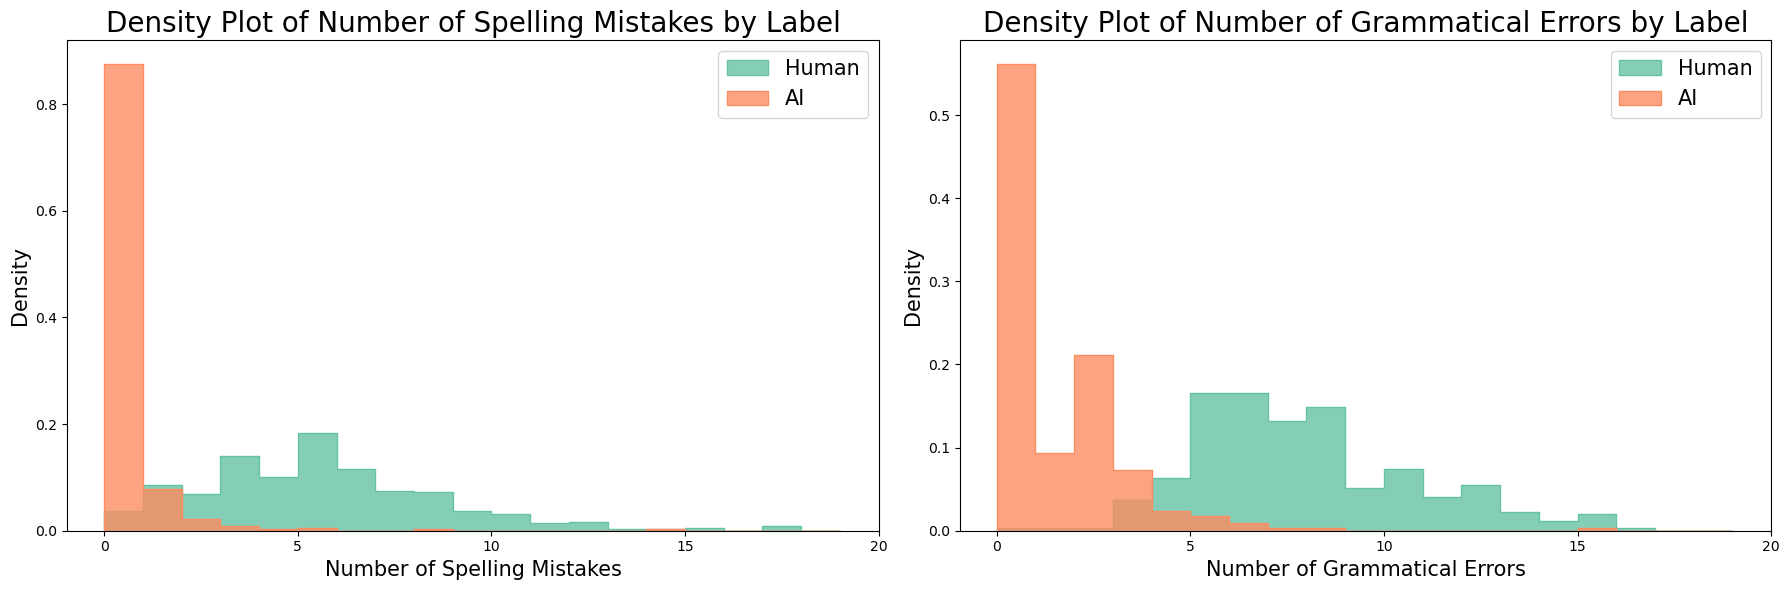

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for number_of_spelling_mistakes
sns.histplot(data=evaldf, x='number_of_spelling_mistakes', hue='Author', hue_order = ['AI', 'Human'], \
             palette=custom_palette,
             element='step', stat='density', common_norm=False, alpha=0.8, bins=range(0, 20), ax=axes[0])
axes[0].set_title('Density Plot of Number of Spelling Mistakes by Label', fontsize=20)
axes[0].set_xlabel('Number of Spelling Mistakes', fontsize=15)
axes[0].set_ylabel('Density', fontsize=15)
axes[0].legend(title='', labels=['Human', 'AI'], fontsize=15)
axes[0].set_xticks(range(0, 21, 5))  # Set x-ticks at intervals of 5

# Plot for number_of_grammatical_errors
sns.histplot(data=evaldf, x='number_of_grammatical_errors', hue='Author', hue_order = ['AI', 'Human'], \
             palette=custom_palette, element='step', stat='density', common_norm=False, alpha=0.8, bins=range(0, 20), ax=axes[1])
axes[1].set_title('Density Plot of Number of Grammatical Errors by Label', fontsize=20)
axes[1].set_xlabel('Number of Grammatical Errors', fontsize=15)
axes[1].set_ylabel('Density', fontsize=15)
axes[1].legend(title='', labels=['Human', 'AI'], fontsize=15)
axes[1].set_xticks(range(0, 21, 5))  # Set x-ticks at intervals of 5

plt.tight_layout()
plt.show()


In [164]:
ordinal_evaluation_keys = [ 'sentence_complexity',
 'lexical_diversity',
 'vocabulary_sophistication',
 'coherence_score',
 'cohesion_score',
 'argument_structure',
 'readability_index',
 'sentence_clarity',
 'engagement_score',
 'sentiment_alignment',
 'style_consistency',
 'relevance_score',
 'evidence_support',
 'originality_and_creativity', 'likelihood_of_ai']

In [167]:
evaldf.groupby('Author')[ordinal_evaluation_keys ].mean()

,sentence_complexity,lexical_diversity,vocabulary_sophistication,coherence_score,cohesion_score,argument_structure,readability_index,sentence_clarity,engagement_score,sentiment_alignment,style_consistency,relevance_score,evidence_support,originality_and_creativity,likelihood_of_ai
Author,,,,,,,,,,,,,,,
AI,3.776435,3.870091,3.353474,4.299094,4.199396,4.247734,3.981873,4.184290,3.507553,4.211480,4.419940,4.975831,3.432024,3.513595,2.135952
Human,2.475783,2.894587,2.159544,3.019943,2.809117,3.054131,3.219373,2.917379,2.857550,3.438746,3.133903,4.370370,2.541311,3.079772,2.891738


In [182]:
import warnings

warnings.filterwarnings('ignore')

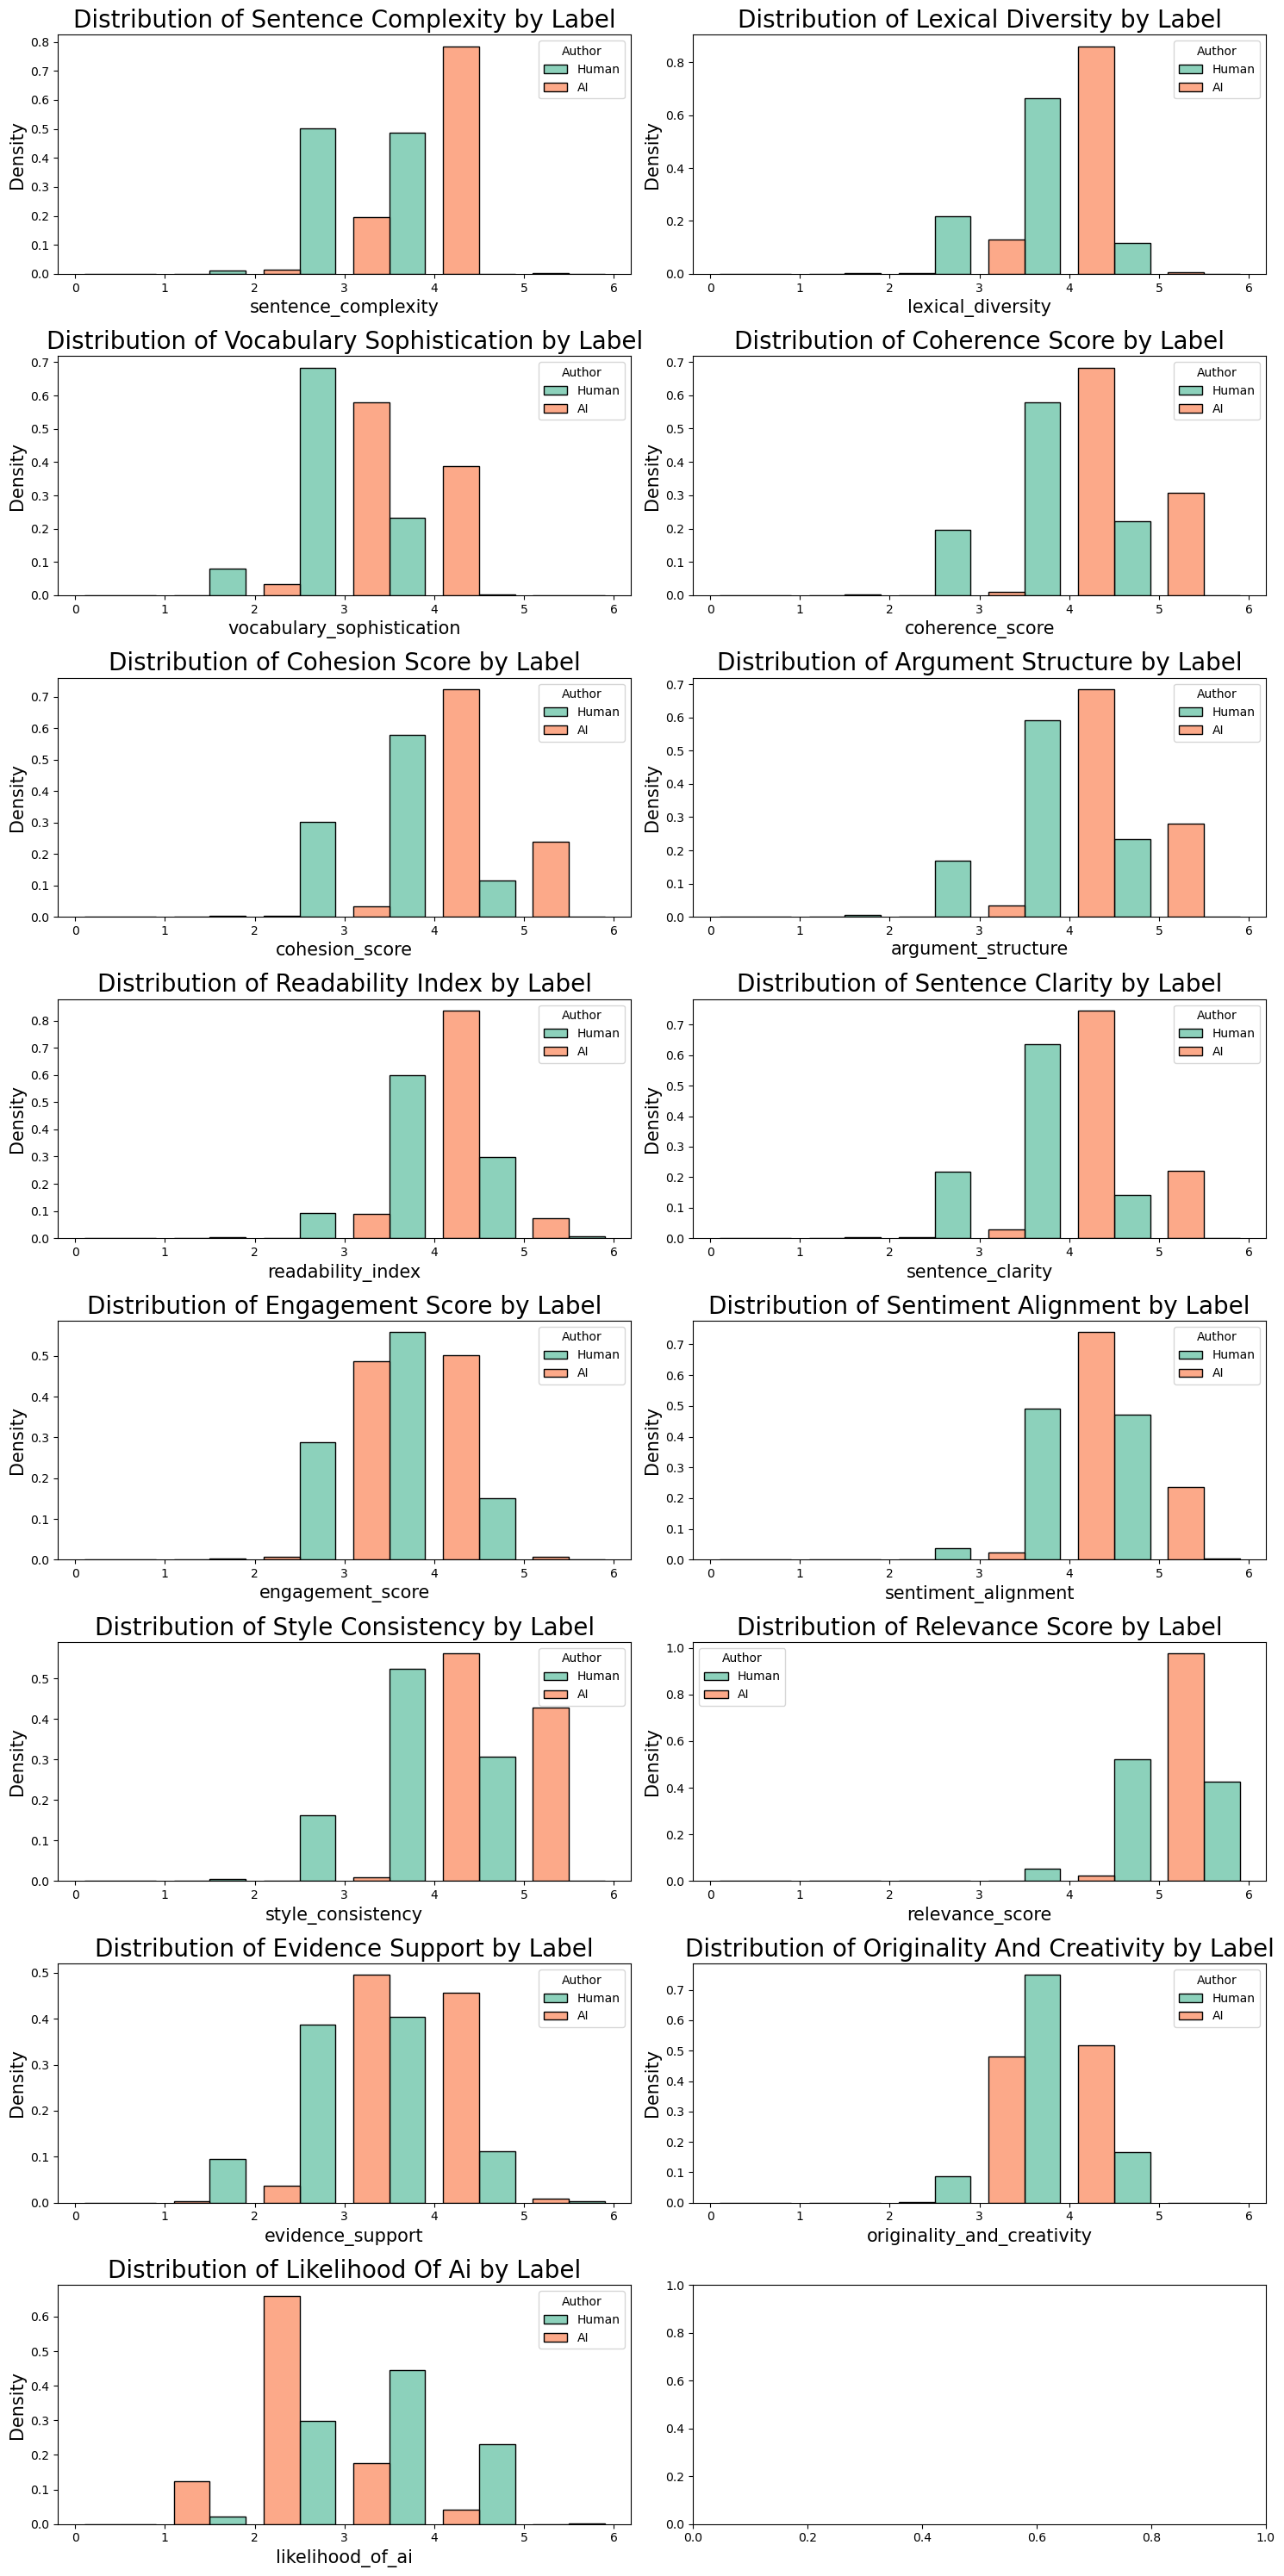

In [183]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))
axes = axes.flatten()

# Plot each ordinal evaluation key
for i, key in enumerate(ordinal_evaluation_keys):
    sns.histplot(data=evaldf, x=key, hue='Author', hue_order = ['AI', 'Human'],  multiple='dodge', shrink=0.8, ax=axes[i], palette=custom_palette,  bins=range(7), stat='density', common_norm=False)
    title = key.replace('_', ' ').title()
    axes[i].set_title(f'Distribution of {title} by Label', fontsize=20)
    axes[i].set_xlabel(key, fontsize=15)
    axes[i].set_ylabel('Density', fontsize=15)
    axes[i].legend(title='Author', labels=['Human', 'AI'])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
hue_order = [
 'persuade_corpus',
 'darragh_claude_v7',
 'llama_70b_v1',
 'llama_falcon_v3_falcon_180b',
 'Mistral7B_CME_v7',
 'mistralai/Mistral-7B-Instruct-v0.1',
 'nima_gpt4',
 'radekgpt4']

In [ ]:
evaldf.to_pickle(f'{topic}_evaldf.pkl')
evaldf.to_csv(f'{topic}_evaldf.csv', index=False)

# Statistical significance: yes, those are some statistically significant identifiers. 

In [194]:
evaluation_keys = ['number_of_spelling_mistakes', 'number_of_grammatical_errors'] + ordinal_evaluation_keys

In [195]:
from scipy.stats import ttest_ind
print(evaldf.shape)

# Initialize a dictionary to store the results
comparison_results = {}

# Loop through each evaluation key
for key in evaluation_keys:
    # Separate the data based on the binary labela
    group_0 = evaldf[evaldf['Author'] == 'Human'][key]
    group_1 = evaldf[evaldf['Author'] == 'AI'][key]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
    
    # Store the results
    comparison_results[key] = {'t_stat': t_stat, 'p_value': p_value}

# Display the results
for key, result in comparison_results.items():
    print(f"{key}: t_stat = {result['t_stat']:.4f}, p_value = {result['p_value']:.4f}")

(682, 33)
number_of_spelling_mistakes: t_stat = 25.6518, p_value = 0.0000
number_of_grammatical_errors: t_stat = 35.1445, p_value = 0.0000
sentence_complexity: t_stat = -34.5937, p_value = 0.0000
lexical_diversity: t_stat = -26.5435, p_value = 0.0000
vocabulary_sophistication: t_stat = -28.5472, p_value = 0.0000
coherence_score: t_stat = -29.2062, p_value = 0.0000
cohesion_score: t_stat = -32.1920, p_value = 0.0000
argument_structure: t_stat = -26.8879, p_value = 0.0000
readability_index: t_stat = -19.0548, p_value = 0.0000
sentence_clarity: t_stat = -30.3683, p_value = 0.0000
engagement_score: t_stat = -14.3255, p_value = 0.0000
sentiment_alignment: t_stat = -19.4200, p_value = 0.0000
style_consistency: t_stat = -27.7349, p_value = 0.0000
relevance_score: t_stat = -18.7111, p_value = 0.0000
evidence_support: t_stat = -16.2525, p_value = 0.0000
originality_and_creativity: t_stat = -11.3017, p_value = 0.0000
likelihood_of_ai: t_stat = 13.4949, p_value = 0.0000


# ignore from here

In [18]:
with open('./utils/prompt_quantitative.txt', 'r') as file:
    prompt = file.read()

formatted_prompt = prompt.format(metric_class_name=QuantitativeTextQualityMetrics.__name__)
evaluator1 = EssayEvaluator(formatted_prompt, "gpt-4o-mini", QuantitativeTextQualityMetrics)



In [24]:
rawtext1 = df['text'][0]
rawtext1 = ' '.join(rawtext1.split(' '))
text1 = df['text_embedded'][0]

In [25]:
# Evaluate using the first evaluator
result1 = evaluator1.evaluate_essay(text1)

In [26]:
rawresult1 = evaluator1.evaluate_essay(rawtext1)

In [27]:
dict(rawresult1)

{'number_of_grammatical_errors': 11,
 'number_of_spelling_mistakes': 2,
 'grammatical_errors': ['no stop',
  'just have group Chats',
  'People always be on their phones',
  "that's called no texting while driving",
  "that's the only way how did he save",
  'makes you puzzled and make you start to freak out',
  "that's why there's a thing",
  "If you go through a problem and you can't find help you ,always have a phone there with you",
  "do not be like this phone while you're in the middle of driving",
  'the best way to come over help',
  'The news always updated when people do something stupid around that involves their phones.'],
 'spelling_mistakes': ['class rooms', 'Problems']}

In [28]:
dict(evaluator1.evaluate_essay("I can't find my phone. Have you seen it somewhere? I ' ve been looking for it all over. "))

{'number_of_grammatical_errors': 1,
 'number_of_spelling_mistakes': 0,
 'grammatical_errors': ["I ' ve been looking for it all over."],
 'spelling_mistakes': []}